In [5]:
!pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [7]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [8]:
vgg = vgg19_modified().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.2MB/s]


In [9]:
!wget https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
!wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

--2023-07-21 08:52:31--  https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/z1y0fy2r6z6m6py/60.jpg [following]
--2023-07-21 08:52:32--  https://www.dropbox.com/s/raw/z1y0fy2r6z6m6py/60.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc526925227e4a998868d445ccc8.dl.dropboxusercontent.com/cd/0/inline/CASvH62K5_X_gzzCCAxhYsivo7UpkDLkMimHOwQM71VRr4LXngPJwCxo9mkwi-FJrzpzxW2HmQ04aHoZJeKs3MWJskU7RahyXXjvFHVQeKQQA42G3cTWC1lH1FQsytnmPR6sUWrIcVcL1YV0ZlAFuYZjERYlFRtJxcnzKxXez-PEvA/file# [following]
--2023-07-21 08:52:32--  https://uc526925227e4a998868d445ccc8.dl.dropboxusercontent.com/cd/0/inline/CASvH62K5_X_gzzCCAxhYsivo7UpkDLkMimHOwQM71VRr4LXngPJwCxo9mkwi-FJrzpzxW2HmQ04aHoZJeKs3MWJskU7RahyXX

In [10]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [11]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [12]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [13]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [14]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [15]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [16]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [17]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000  loss: 9722747.000  (74.27s - -0.30s remaining)

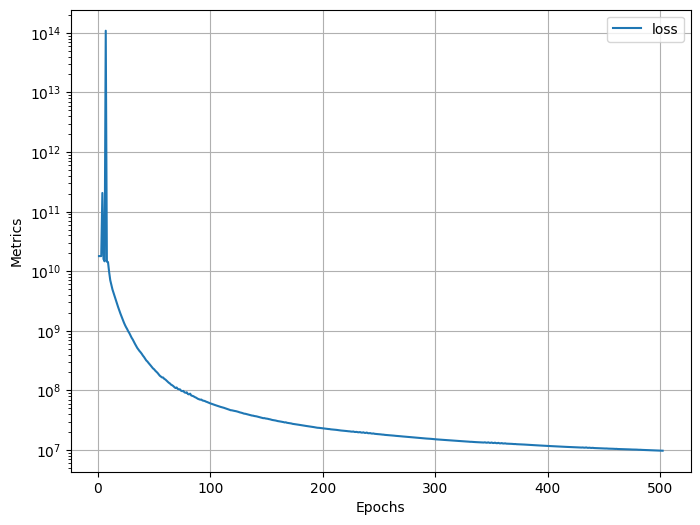

In [18]:
log.plot(log=True)

In [19]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)

tensor([[[ 0.5172,  0.8406,  0.8683],
         [ 0.0252,  0.2790,  0.7411],
         [ 0.1049,  0.6626,  0.8932],
         ...,
         [ 0.6233,  0.1437,  0.3795],
         [ 0.6277,  0.1609,  0.0999],
         [ 0.0110, -0.1539, -0.0419]],

        [[ 0.9975,  0.5478,  0.2006],
         [ 0.7722,  0.0708,  0.1485],
         [ 0.5758,  0.4579,  0.4192],
         ...,
         [ 0.7898, -0.0270,  0.1774],
         [ 0.2642, -0.1248, -0.1301],
         [ 0.0455, -0.0749, -0.3237]],

        [[ 1.0304,  0.3905,  0.3210],
         [ 1.0090,  0.0252,  0.1353],
         [ 0.7293,  0.2419,  0.4736],
         ...,
         [ 0.4175, -0.2157,  0.1258],
         [-0.0481, -0.0676, -0.0779],
         [-0.0122,  0.0342, -0.4710]],

        ...,

        [[ 1.0133,  1.3679,  0.7909],
         [ 0.7459,  0.9592,  0.2975],
         [ 0.4263,  0.8907,  0.4449],
         ...,
         [ 0.3154,  0.2560,  0.2131],
         [ 0.2613,  0.2141,  0.1559],
         [ 0.2499,  0.1021,  0.1417]],

        [[